In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from skimage.feature import hog
from lesson_functions import *
%matplotlib inline

In [36]:
# import the python debugger
import pdb

### Read in dataset

In [82]:
# Read in cars and notcars
use_small = False

if use_small:
    image_files = glob.glob('./training_data/smallset/*/*.jpeg')
    car_files = []
    notcar_files = []
    for fname in image_files:
        if 'image' in fname or 'extra' in fname:
            notcar_files.append(fname)
        else:
            car_files.append(fname)

    # Reduce the sample size because
    # The quiz evaluator times out after 13s of CPU time
    sample_size = -1
    car_files = car_files[0:sample_size]
    notcar_files = notcar_files[0:sample_size]
else:
    car_files = glob.glob('./training_data/fullset/vehicles/*/*.png')
    notcar_files = glob.glob('./training_data/fullset/non-vehicles/*/*.png')
    
    sample_size = -1
    car_files = car_files[0:sample_size]
    notcar_files = notcar_files[0:sample_size]

In [83]:
print(len(car_files), len(notcar_files))

8791 8967


In [84]:
img = mpimg.imread(car_files[0])

In [85]:
img.shape

(64, 64, 3)

In [89]:
print(np.max(img), type(np.max(img)))
zimg = img*255
zimg = zimg.astype(np.uint8)
print(np.max(zimg), type(np.max(zimg)))

0.752941 <class 'numpy.float32'>
192 <class 'numpy.uint8'>


In [92]:
type(np.max(cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)))

numpy.float32

In [93]:
type(np.max(cv2.cvtColor(zimg,cv2.COLOR_RGB2YCrCb)))

numpy.uint8

### Set parameters and train model

In [94]:
#---------------------
# Training parameters
#---------------------

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# spatial binning dimensions
spatial = (32,32) # 14 seems optimal

# histogram binsdd
histbin = 32 # 64 seems pretty good

# HOG parameters
orient = 9 #12
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

#--------------------
# Feature extraction
#--------------------

t=time.time()
car_features = extract_features(car_files, color_space=colorspace,
                                spatial_size=spatial, hist_bins=histbin,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcar_files, color_space=colorspace,
                                   spatial_size=spatial, hist_bins=histbin,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
print()

#------------------
# Setup X & y data
#------------------

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#------------------
# Train/Test split
#------------------

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Parameters:')
print(colorspace,'color spaces')
print(spatial[0],'spatial params,', histbin, 'histogram bins')
print('HOG: channels = ',hog_channel)
print(orient,'orientations',pix_per_cell,'pixels per cell and',
      cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print()

# Use a linear SVC 
svc = LinearSVC()

#-------------
# Train model
#-------------

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

142.9 Seconds to extract features...

Parameters:
YCrCb color spaces
32 spatial params, 32 histogram bins
HOG: channels =  ALL
9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460

24.84 Seconds to train SVC...
Test Accuracy of SVC =  0.9941
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  0.]
0.00222 Seconds to predict 10 labels with SVC


### Predict on images
Now that we have:
- X_scaler
- svc

Let's run it on some images...

In [96]:
img = mpimg.imread('./test_images/test1.jpg')

13 bounding boxes found


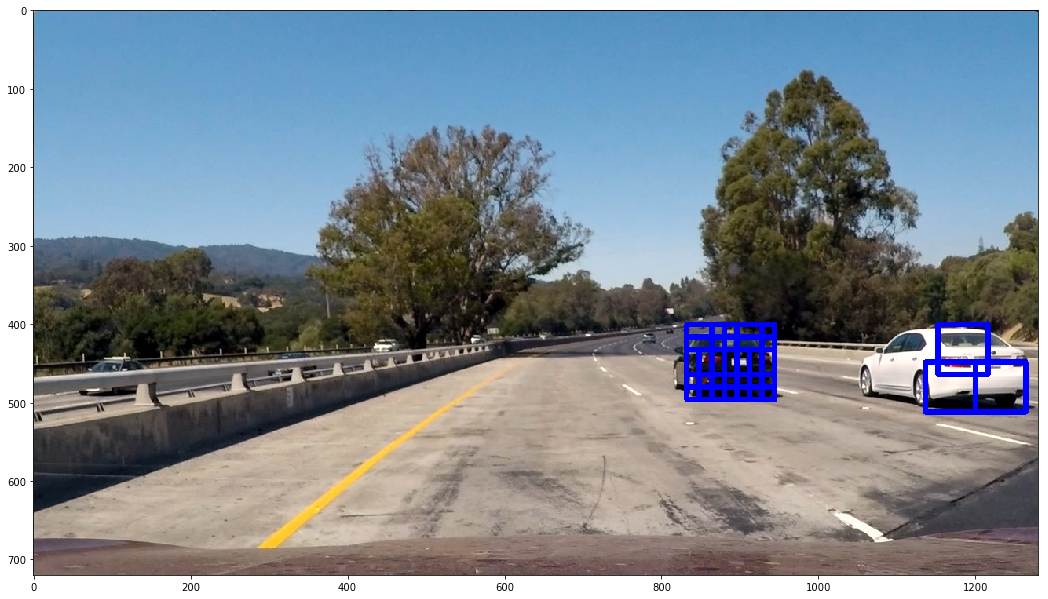

In [102]:
ystart = 400
ystop = 656
scale = 1.0
    
bbox_list, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial, histbin)
plt.figure(figsize=(18,32))
plt.imshow(out_img)
print(len(bbox_list),'bounding boxes found')

10 bounding boxes found


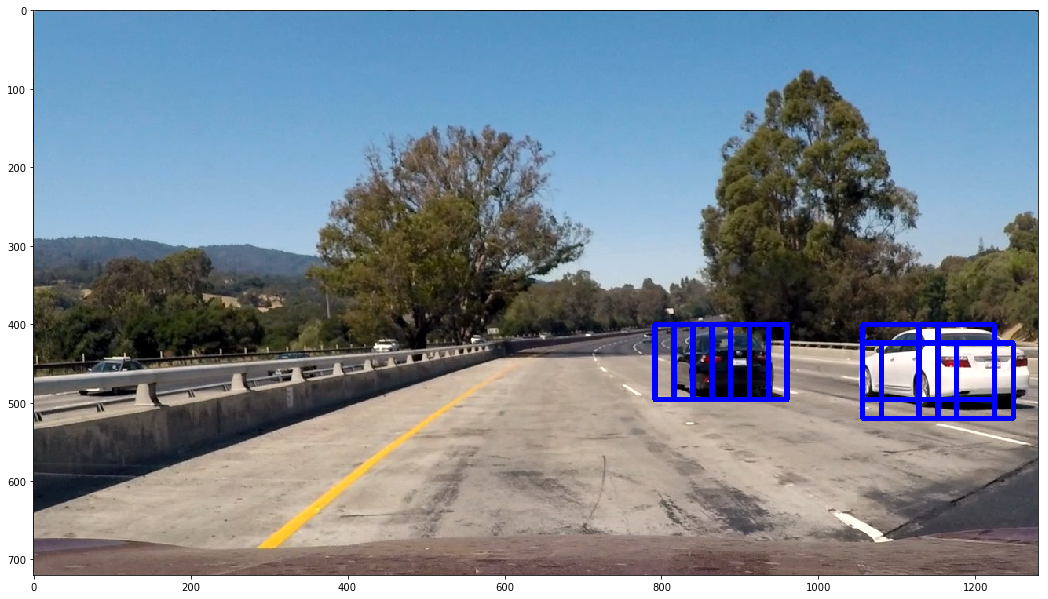

In [103]:
ystart = 400
ystop = 656
scale = 1.5
    
bbox_list, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial, histbin)
plt.figure(figsize=(18,32))
plt.imshow(out_img)
print(len(bbox_list),'bounding boxes found')

3 bounding boxes found


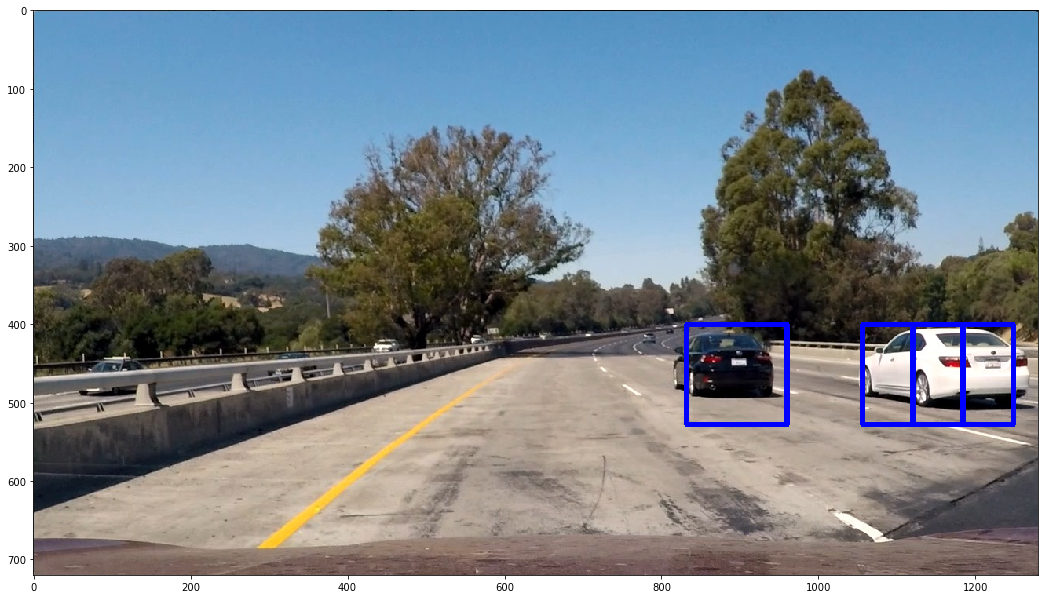

In [104]:
ystart = 400
ystop = 656
scale = 2.0
    
bbox_list, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial, histbin)
plt.figure(figsize=(18,32))
plt.imshow(out_img)
print(len(bbox_list),'bounding boxes found')